In [1]:
from pystock.stock_scanner import Stock, StockScanner
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import f1_score, recall_score, precision_score, make_scorer, accuracy_score, roc_auc_score, classification_report
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization, Bidirectional, Reshape, TimeDistributed, LayerNormalization, Attention
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
tf.random.set_seed(11)
np.random.seed(11)

ModuleNotFoundError: No module named 'pystock'

# Get stock data

In [148]:
s = Stock('TSLA')
s.get_technical_data(start_date=datetime(2018,1,1))
TIME = s.technical.index
T = s.technical[['open','high','low','volume','close',]].copy()
T.shape

(802, 5)

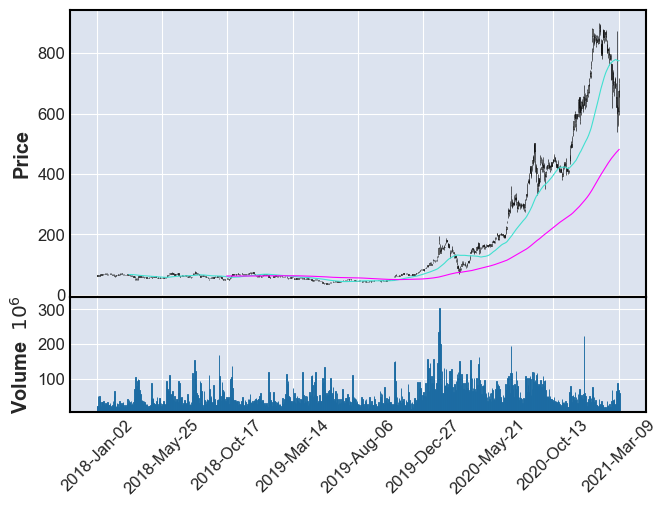

In [3]:
s.plot_chart()

# Preprocess


## Min-max Scaling and Train/Test Split
Below, we apply a min-max scaler to the dataset, and then convert it to a supervised learning problem. Basically, we have "sliding window", that divides the dataset into many different windows of length 20 days, that allow us to predict the 21st day. As the window slides from left to right, we are able to use a LSTM model to predict a "future" day from 20 preceding days.

### Create features for predicting next day close:

In [102]:
scaler_ohlv = StandardScaler() #MinMaxScaler(feature_range=(0,1))
scaler_close = StandardScaler()
T = T.values
T[:,0:4] = scaler_ohlv.fit_transform(T[:,0:4])
T[:,4:] = scaler_close.fit_transform(T[:,4:])

In [103]:
train_size = int(len(T) * 0.8)
test_size = int(len(T) - train_size)
train, test = T[0:train_size, :], T[train_size:, :]
assert T.shape[0] == train.shape[0] + test.shape[0], "Train and test samples must add up to dataset length. Check for leaking of train into test."
train.shape, test.shape

((641, 5), (161, 5))

In [36]:
# Method for create features from the time series data
def create_features(data, window_size):
    """ Create timeseries dataset based on window_size with label being next days close price. """
    X, Y = [], []
    for i in range(len(data) - window_size):
        window = data[i:(i + window_size), :]
        X.append(window)
        Y.append(data[i + window_size, 4])
    return np.array(X), np.array(Y)


# Roughly one month of trading assuming 5 trading days per week
window_size = 20
n_features = train.shape[1]
X_train, y_train = create_features(train, window_size)

X_test, y_test = create_features(test, window_size)

# Reshape to the format of [batch, timesteps, features]
X_train = np.reshape(X_train, (X_train.shape[0], window_size, n_features))

X_test = np.reshape(X_test, (X_test.shape[0], window_size, n_features))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

### Create feature for predicting next day up/down:

<AxesSubplot:>

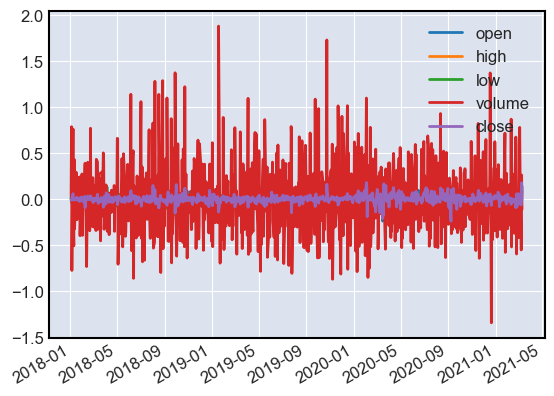

In [168]:
# Data for 
T_binary = np.log(T).diff().copy()
T_binary.plot()

In [169]:
scaler_ohlv = StandardScaler() #MinMaxScaler(feature_range=(0,1))
scaler_close = StandardScaler()
T_binary = T_binary.values[1:] # from 1 becuase first timestep is nan
T_binary[:,0:4] = scaler_ohlv.fit_transform(T_binary[:,0:4])
T_binary[:,4:] = scaler_close.fit_transform(T_binary[:,4:])

In [170]:
train_size = int(len(T_binary) * 0.8)
test_size = int(len(T_binary) - train_size)
train, test = T_binary[0:train_size, :], T_binary[train_size:, :]
assert T_binary.shape[0] == train.shape[0] + test.shape[0], "Train and test samples must add up to dataset length. Check for leaking of train into test."
train.shape, test.shape

((640, 5), (161, 5))

In [206]:
def create_features_binary_from_close_price(data, window_size):
    """ Create timeseries dataset based on window_size of ohlc data with label being up (1) or down (0) the next day."""
    X, Y = [], []
    for i in range(len(data) - window_size):
        window = data[i:(i + window_size), :]
        if window[-1,4] > data[i+window_size, 4]:
            y = 0 # down next day
        else: 
            y = 1 # up next day
        X.append(window)
        Y.append(y)
    return np.array(X), np.array(Y)

def create_features_binary(data, window_size):
    """ Create timeseries dataset based on window_size of differenced ohlc data with label being up (1) or down (0) the next day."""
    X, Y = [], []
    for i in range(len(data) - window_size):
        window = data[i:(i + window_size), :]
        if data[i+window_size, 4] < 0:
            y = 0 # down next day
        else: 
            y = 1 # up next day
        X.append(window)
        Y.append(y)
    return np.array(X), np.array(Y)

# Roughly one month of trading assuming 5 trading days per week
window_size = 20
n_features = train.shape[1]
X_train, y_train = create_features_binary(train, window_size)

X_test, y_test = create_features_binary(test, window_size)

# Reshape to the format of [batch, timesteps, features]
X_train = np.reshape(X_train, (X_train.shape[0], window_size, n_features))

X_test = np.reshape(X_test, (X_test.shape[0], window_size, n_features))

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((620, 20, 5), (141, 20, 5), (620,), (141,))

# Building and training the LSTM RNN Model
Below, we build a LSTM model that consists of one LSTM layer with a density of 50 neurons and a RELU activation function, as well as a Dropout regularization layer. We add a model checkpoint that is looking to minimize the validation set's loss. We save each model that consists of a lower validation loss compared to any model that came before it.

In [207]:
# Building model
model = Sequential()

# model.add(Bidirectional(LSTM(units = 50, activation = 'relu', return_sequences = False), 
#                         input_shape = (None, X_train.shape[2])
#                        )
#          )
model.add(LSTM(units = 100, activation = 'relu', return_sequences = False, input_shape = (None, X_train.shape[2])))
model.add(LayerNormalization())
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid')) # use activation='linear' for predicting price instead of binary label
model.compile(loss = 'binary_crossentropy', optimizer = 'adam') # use loss = 'mean_squared_error' for predicting price instead of binary label

In [208]:
model.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 100)               42400     
_________________________________________________________________
layer_normalization_17 (Laye (None, 100)               200       
_________________________________________________________________
dropout_23 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 101       
Total params: 42,701
Trainable params: 42,701
Non-trainable params: 0
_________________________________________________________________


In [209]:
filepath = 'nn_snapshots/model_epoch_{epoch:02d}.hdf5'

checkpoint = ModelCheckpoint(filepath = filepath,
                             monitor = 'val_loss',
                             verbose = 1,
                             save_best_only = True,
                             mode ='min'
                            )

history = model.fit(X_train, y_train, 
                    epochs = 100, 
                    batch_size = 20, 
                    validation_data = (X_test, y_test), 
                    callbacks = [checkpoint], 
                    verbose = 1, 
                    shuffle = False)

Epoch 1/100
31/31 [==============================] - 1s 14ms/step - loss: 0.7865 - val_loss: 0.7356

Epoch 00001: val_loss improved from inf to 0.73555, saving model to nn_snapshots\model_epoch_01.hdf5
Epoch 2/100
31/31 [==============================] - 0s 8ms/step - loss: 0.7599 - val_loss: 0.7377

Epoch 00002: val_loss did not improve from 0.73555
Epoch 3/100
31/31 [==============================] - 0s 8ms/step - loss: 0.7546 - val_loss: 0.7430

Epoch 00003: val_loss did not improve from 0.73555
Epoch 4/100
31/31 [==============================] - 0s 8ms/step - loss: 0.7509 - val_loss: 0.7458

Epoch 00004: val_loss did not improve from 0.73555
Epoch 5/100
31/31 [==============================] - 0s 8ms/step - loss: 0.7207 - val_loss: 0.7325

Epoch 00005: val_loss improved from 0.73555 to 0.73248, saving model to nn_snapshots\model_epoch_05.hdf5
Epoch 6/100
31/31 [==============================] - 0s 8ms/step - loss: 0.7331 - val_loss: 0.7085

Epoch 00006: val_loss improved from 0.73

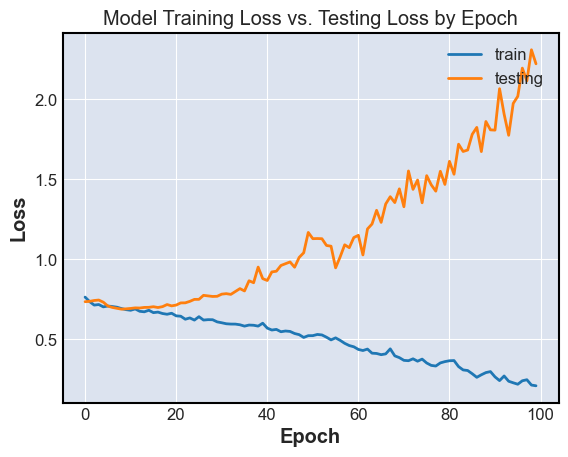

In [210]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Training Loss vs. Testing Loss by Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'testing'], loc='upper right')
plt.show()

In [211]:
np.argmin(history.history['val_loss'])

8

# Evaluate closing price model

In [30]:
best_model = load_model('nn_snapshots/model_epoch_01.hdf5')

# Predicting and inverse transforming the predictions

y_pred_train = best_model.predict(X_train)

y_pred_train = scaler_close.inverse_transform(y_pred_train).reshape(-1,)

y_pred_test = best_model.predict(X_test)

y_pred_test = scaler_close.inverse_transform(y_pred_test).reshape(-1,)

# Inverse transforming the actual values, to return them to their original values
y_test = scaler_close.inverse_transform([y_test]).reshape(-1,)
y_train = scaler_close.inverse_transform([y_train]).reshape(-1,)

In [31]:
train_RMSE = np.sqrt(mean_squared_error(y_train, y_pred_train))

test_RMSE = np.sqrt(mean_squared_error(y_test, y_pred_test))

print('Train RMSE is: ')
print(train_RMSE, '\n')
print('Test RMSE is: ')
print(test_RMSE)

Train RMSE is: 
8.63390538404823 

Test RMSE is: 
71.79325975143182


In [32]:
result_df = pd.DataFrame()

result_df['close_true'] = np.concatenate([y_train, y_test])
result_df['close_pred'] = np.concatenate([y_pred_train, y_pred_test])
result_df['close_true_up'] = result_df['close_true'].diff()>0
result_df['close_pred_up'] = result_df['close_pred'].diff()>0

result_df.tail()

,close_true,close_pred,close_true_up,close_pred_up
756,653.200012,804.729858,False,True
757,621.440002,788.487305,False,False
758,597.950012,792.461975,False,True
759,563.000000,767.686279,False,False
760,673.580017,763.257263,True,False


In [33]:
accuracy_score(result_df['close_true_up'], result_df['close_pred_up'])

0.5269382391590013

<AxesSubplot:>

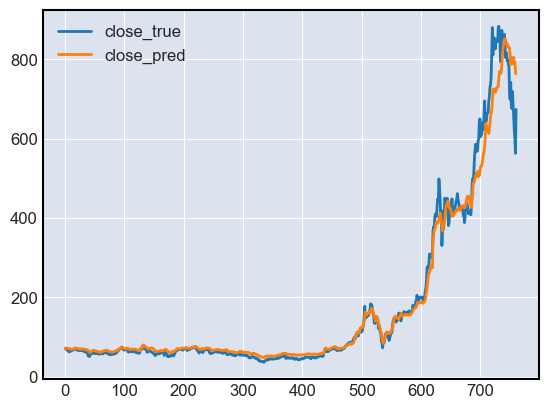

In [34]:
result_df.plot()

# Evaluate binary model (up/down)

In [212]:
best_model = load_model('nn_snapshots/model_epoch_09.hdf5')
y_pred_train = (best_model.predict(X_train)>0.5).astype(int)
y_pred_test = (best_model.predict(X_test)>0.5).astype(int)
accuracy_score(y_train, y_pred_train), accuracy_score(y_test, y_pred_test)

(0.614516129032258, 0.5602836879432624)

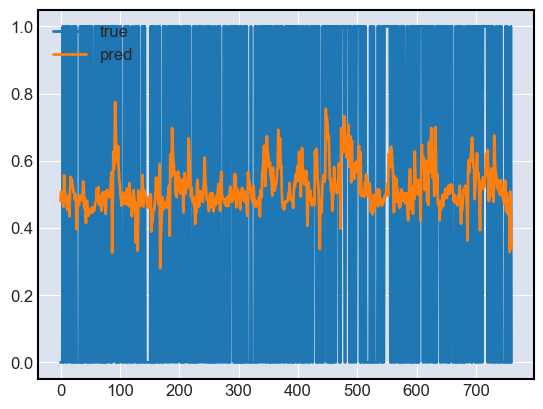

In [213]:
plt.plot(np.concatenate([y_train,y_test]), label='true')
plt.plot(np.concatenate([best_model.predict(X_train),best_model.predict(X_test)]),label='pred')
plt.legend()

# Predict close tomorrow

In [35]:
X_today = T[-20:,:]
y_tmr = best_model.predict(X_today.reshape(-1,X_today.shape[0], n_features))
y_tmr = scaler_close.inverse_transform(y_tmr)
y_tmr

array([[773.33075]], dtype=float32)